In [1]:
import glob
import re
import bs4
import cltk
import nltk
import json

import numpy as np
from collections import defaultdict, Counter
from nltk.tokenize.punkt import PunktLanguageVars

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram   

from sklearn.feature_extraction.text import TfidfVectorizer
from cltk.stop.latin.stops import STOPS_LIST

import itertools

stop_words = STOPS_LIST.extend(['quod', 'vel', 'sunt', 'hoc', 'vero', 'sit', 'sol', 'que', 'esse'])

%matplotlib inline

In [2]:
from cltk.corpus.utils.importer import CorpusImporter

corpus_importer = CorpusImporter('latin')
corpus_importer.import_corpus('latin_text_latin_library')
corpus_importer.import_corpus('latin_pos_lemmata_cltk')
corpus_importer.import_corpus('latin_models_cltk')

INFO:CLTK:Pulling latest 'latin_text_latin_library' from 'https://github.com/cltk/latin_text_latin_library.git'.
ERROR:CLTK:Git pull of 'https://github.com/cltk/latin_text_latin_library.git' failed: ''Error when fetching: fatal: unable to access 'https://github.com/cltk/latin_text_latin_library.git/': Could not resolve host: github.com' returned with exit code 2'
INFO:CLTK:Pulling latest 'latin_pos_lemmata_cltk' from 'https://github.com/cltk/latin_pos_lemmata_cltk.git'.
ERROR:CLTK:Git pull of 'https://github.com/cltk/latin_pos_lemmata_cltk.git' failed: ''Error when fetching: fatal: unable to access 'https://github.com/cltk/latin_pos_lemmata_cltk.git/': Could not resolve host: github.com' returned with exit code 2'
INFO:CLTK:Pulling latest 'latin_models_cltk' from 'https://github.com/cltk/latin_models_cltk.git'.
ERROR:CLTK:Git pull of 'https://github.com/cltk/latin_models_cltk.git' failed: ''Error when fetching: fatal: unable to access 'https://github.com/cltk/latin_models_cltk.git/': C

In [113]:
"""This corpus comes from the Thesaurus Musicarum Latinarum.
If you want to replicate these results, you should grab the
corpus with a recursive wget or similar."""

corpus_files = glob.glob('corpus/html/*.html')

In [4]:
soups = [bs4.BeautifulSoup(open(file), 'lxml') for file in corpus_files]

In [137]:
def process_soup(soup):
    "Takes a bs4 BeautifulSoup object and returns a dict with document content and metadata."
    corpus_item = {}
    
    header = soup.find('p')

    original = " ".join([n for n in soup.findAll(text=True)])
    
    body = "".join([p.text for p in soup.findAll('p')[1:]])
    body = remove_newlines(body)
    body = remove_doublespace(body)
    body = remove_editorial_apparatus(body)
    body = join_hyphens(body)
    
    century_re = re.compile('.*www.chmtl.indiana.edu\/tml\/(\w+\W*\w+)\/.*')
    
    try:
        comments = "".join(soup.findAll(text=lambda text:isinstance(text, bs4.Comment)))
        century = century_re.match(comments).groups()[0]
        corpus_item['century'] = century
    except:
        corpus_item['century'] = 'nd'

    corpus_item['body'] = body.strip()
    corpus_item['id'] = soup.title.text.split(' ')[0]
    
    match = re.search(r"Author:\s(.*)", original)
    
    if match:
        result = match.group(1)
    else:
        result = ""
    
    corpus_item['author'] = result
    
    match = re.search(r"Title:\s(.*)", original)
    
    if match:
        result = match.group(1)
    else:
        result = ""
        
    corpus_item['title'] = result
    
    return corpus_item

def remove_editorial_apparatus(text):
    "Removes all text enclosed in square brackets."
    pattern = re.compile('\[.+?\]')
    return pattern.sub('', text)

def remove_newlines(text):
    "Replaces newlines with spaces."
    return text.replace('\n', ' ')

def remove_doublespace(text):
    "Removes any doublespaces."
    return text.replace('  ', ' ')

def join_hyphens(text):
    "Joins hyphens used at ends of lines."
    return text.replace('-\n', '')

def my_tokenize(document):
    "Tokenizes a document, represented as a string using Punkt."
    p = PunktLanguageVars()
    tokens = p.word_tokenize(document)
    tokens = [x.lower() for x in tokens if x not in (',', ';', '.', "'", '"',':',')','(', '|' , '||' )]
    return tokens

In [124]:
corpus = []

for soup in soups:
    try:
        corpus_item = process_soup(soup)    
        corpus.append(corpus_item)
    except:
        continue

NameError: name 'soups' is not defined

In [19]:
# Save to disk 

with open('corpus.json', 'w') as fp:
    json.dump(corpus, fp)

In [3]:
# Load pre-parsed corpus

with open('corpus.json', 'r') as fp:
    corpus = json.load(fp)

In [4]:
len(corpus)

807

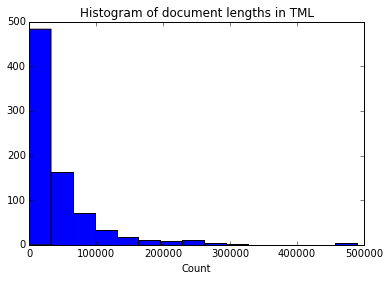

In [5]:
lengths = [len(x['body']) for x in corpus]
plt.hist(lengths, bins=15)
plt.title('Histogram of document lengths in TML')
plt.xlabel('Length of doc (chars)')
plt.xlabel('Count')
plt.show()

In [14]:
# Write texts stripped of boilerplate for use externally 

import unidecode

for item in corpus:
    with open('./corpus/body/{}.txt'.format(item['id']), 'w') as f:
        f.write(unidecode.unidecode(item['body']))

In [6]:
def prepare_id_info_map(corpus):
    id_info_map = {}
    for item in corpus:
        item_copy = item.copy()
        del item_copy['body']
        id_info_map[item['id']] = item_copy
    return id_info_map

In [7]:
id_info_map = prepare_id_info_map(corpus)

In [8]:
id_info_map['AARIH1']

{'author': 'Aaron, Petrus',
 'century': '16th',
 'id': 'AARIH1',
 'title': 'De institutione harmonica, liber primus'}

## Topic Modeling with `gensim`

In [142]:
import gensim
from cltk.stem.lemma import LemmaReplacer

In [143]:
# Code that's useful for preparing the corpus for analysis with gensim.
# Vector space models sometimes perform better when stopwords etc. are filtered out
# I lemmatize the Latin for the fun of it. Note this prep() function is not used
# in the text reuse part of this notebook

lemmatizer = LemmaReplacer('latin')

def filter_stopwords(tokens):
    "Filters stopwords from list of tokens."
    return [token for token in tokens if token not in STOPS_LIST]

def filter_shortwords(tokens, short_size=2):
    "Filters tokens of size greater than short_size from list of tokens."
    return [token for token in tokens if len(token) > short_size]

def prep(document):
    "A convenience function which applies a series of operations to a document represented in a string."
    tokenized = my_tokenize(document)
    stopped = filter_stopwords(tokenized)
    shorted = filter_shortwords(stopped)
    lemmatized = lemmatizer.lemmatize(shorted)
    done = shorted
    return done

In [144]:
documents = [prep(doc['body']) for doc in corpus]

In [145]:
dictionary = gensim.corpora.Dictionary(documents)

In [29]:
bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
len(bow_corpus)

807

In [30]:
# Save the sparse matrix corresponding to the BoW representation of the corpus

gensim.corpora.MmCorpus.serialize('tml.mm', bow_corpus)

In [31]:
# Retrieve the sparse matrix corresponding to the BoW representation of the corpus

bow_corpus = gensim.corpora.MmCorpus('tml.mm')

In [32]:
# Make a tf-idf model for the corpus
tfidf = gensim.models.TfidfModel(bow_corpus, normalize=True)

# Get vectors full of tf-idf scores for the words in the BoW representation
tfidf_corpus = tfidf[bow_corpus]

In [33]:
# Now do LSI with that 

lsi = gensim.models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=150)

In [41]:
lsi.print_topics(10)

['0.141*"tonus" + 0.137*"longus" + 0.135*"brevis" + 0.131*"proportio" + 0.128*"diapente" + 0.122*"diapason" + 0.120*"diatessaron" + 0.116*"semibreves" + 0.109*"tempus" + 0.107*"imperfectus"',
 '-0.257*"semibreves" + -0.249*"brevis" + -0.248*"longus" + -0.230*"semibrevis" + -0.179*"prolatio" + -0.174*"tempus" + -0.171*"imperfectus" + -0.153*"ligo1" + -0.150*"pungo" + -0.147*"minimus"',
 '0.362*"proportio" + 0.209*"numerus" + 0.154*"terminus" + -0.152*"finalis" + 0.131*"multiplex" + 0.102*"hypaton" + 0.100*"diezeugmenon" + -0.099*"antiphona" + 0.095*"meson" + 0.090*"diapason"',
 '0.273*"meson" + 0.259*"diezeugmenon" + 0.252*"hypaton" + -0.228*"proportio" + 0.193*"meses" + 0.190*"hypate" + 0.184*"hyperboleon" + 0.172*"lichanos" + 0.159*"paranete" + 0.154*"neo1"',
 '0.189*"dyapente" + 0.144*"diapente" + 0.134*"tonus" + 0.130*"dyapason" + 0.124*"discantus" + 0.120*"ascendo" + 0.117*".a." + 0.113*".d." + 0.107*".c." + 0.106*"dyatessaron"',
 '0.363*".a." + 0.345*".d." + 0.303*".c." + 0.277*".

## Focusing on a subset

This is some code to restrict sample to a certain set of parameters

TODO: Make a proper query interface for corpus entries

In [110]:
q_century = '15th'
q_min_size = 25000
q_max_size = 10000000

sample = [treatise for treatise in corpus\
          if treatise['century'] == q_century\
          and len(treatise['body']) < q_max_size\
          and len(treatise['body']) > q_min_size]

sample = corpus

bodys = [treatise['body'] for treatise in sample]
lens = [str(len(treatise['body'])) for treatise in sample]

ids = [treatise['id'] for treatise in sample]
titles = [treatise.get('title', 'nt')[:15] for treatise in sample]
authors = [treatise.get('author', 'na')[:15] for treatise in sample]


len(sample) , len(ids), len(titles)

(807, 807, 807)

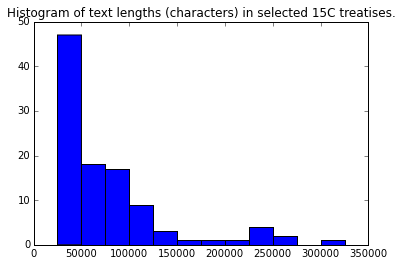

In [75]:
lengths = [len(treatise['body']) for treatise in sample]
plt.hist(lengths, bins=12)
plt.title('Histogram of text lengths (characters) in selected 15C treatises.')
plt.show()

## Text Similarity - Ward clustering in tf-idf space

In [146]:
documents = [doc['body'] for doc in corpus]

tfidf = TfidfVectorizer(tokenizer=prep, stop_words=stop_words)
tfs = tfidf.fit_transform(documents)

In [147]:
# Recall that bodys is the sample only from the 15C

bodys = [" ".join(prep(doc)) for doc in bodys]

tfs = tfidf.transform(bodys)
tfs.shape

dist = 1 - cosine_similarity(tfs)

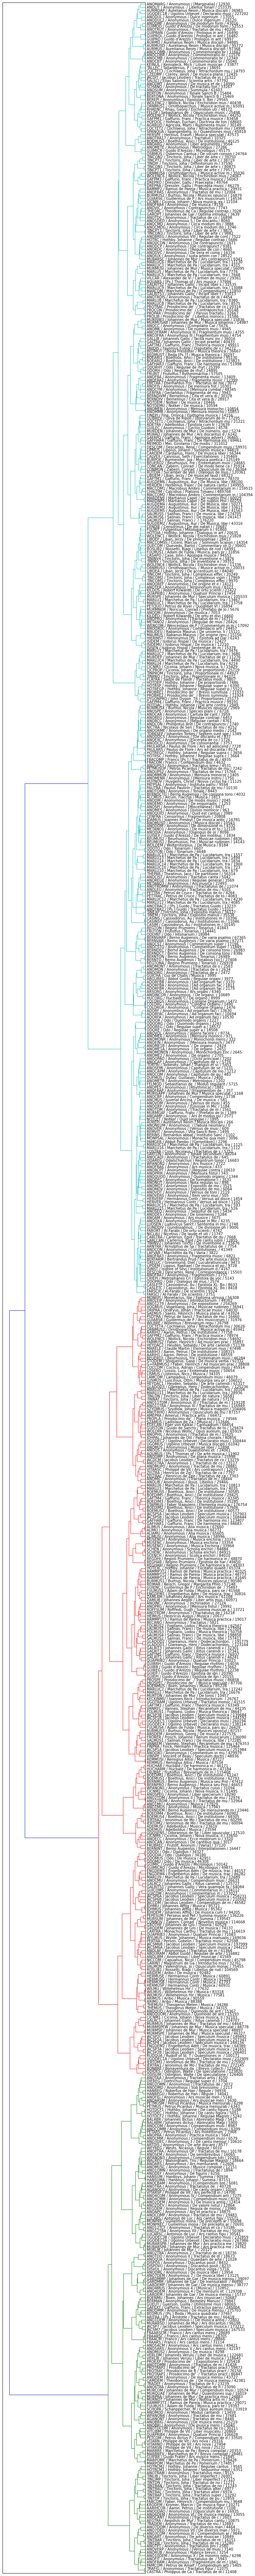

In [149]:
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(10, 100)) # set size
labels = [" / ".join(t) for t in zip(ids, authors, titles, lens)]
ax = dendrogram(linkage_matrix, orientation="right", labels=labels);

plt.tick_params(axis='x',          
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')

plt.tight_layout() 

## Text reuse - Viral Texts

Reimplementation of the Viral Texts methodology

viraltexts.org

Note that this is done at the "section" level - will need to "sectionize" documents first.

Part I. Identify document pair candidates

1. Pick out a subset of all the texts for testing purposes
2. Sectionalize
3. ~~Make a hashmap id -> tokenized text~~
4. Make a hashmap id -> shingled text
5. For each n-gram, create a list of (d_i, p_i) - document ID and position ID
6. Exclude singleton n-grams
7. Extract candidate pairs
8. Filter (e.g. suppress n-grams that generate more than some fixed number of pairs)
9. Rank

Part II. Local document alignment

1. Do Smith-Waterman on top pairs

In [9]:
import random

N = 5

def zipngram(document_tokens,n=N):
    return zip(*[document_tokens[i:] for i in range(n)])

In [10]:
def prepare_ngram_index(id_shingled_map):
    "Make a dict with"
    ngram_index = defaultdict(list)
    
    for _id, shingled_rep in id_shingled_map.items():
        for position, n_gram in enumerate(shingled_rep):
            ngram_index[n_gram].append((_id, position))
    
    return ngram_index

def filter_singletons(ngram_index):
    # Naive implementation not advised in article
    # TODO: Implement nice two-pass hash fxn. method
    filtered_ngram_index = {}
    
    for ngram, locations in ngram_index.items():
        if len(locations) > 1:
            filtered_ngram_index[ngram] = locations
    
    return filtered_ngram_index

def prepare_id_tokenized_map(corpus):
    id_tokenized_map = {}
    
    for text in corpus:
        id_tokenized_map[text['id']] = my_tokenize(text['body'])
        
    return id_tokenized_map

def prepare_id_body_map(corpus):
    id_body_map = {}
    
    for text in corpus:
        id_body_map[text['id']] = text['body']
            
    return id_body_map 

def prepare_id_shingled_map(corpus): 
    id_shingled_map = {}
    
    for text in corpus:
        tokenized_body = my_tokenize(text['body'])
        id_shingled_map[text['id']] = [ngram for ngram in zipngram(tokenized_body, N)]
    
    return id_shingled_map

def prepare_pair_ngrams_map(ngram_index):
    pair_ngrams_map = defaultdict(list)
    
    for ngram, locations in ngram_index.items():
        documents = list(set([location[0] for location in locations]))
        for p in itertools.combinations(documents, 2):
            # This is where we test authorship
            # We dump those pairs where there's a shared author
            # TODO: Make robust
            if p[0][:3] != p[1][:3]:
                pair_ngrams_map[p].append(ngram)
    
    return pair_ngrams_map

In [11]:
corpus[0].keys()

dict_keys(['century', 'id', 'title', 'body', 'author'])

In [12]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]
    
def sectionalize_corpus(corpus, section_length=50):
    "Split the corpus into chunks of (section_length) words."
    sectionalized_corpus = []
    for item in corpus:
        words = item['body'].split(' ')
        for index, chunk in enumerate(chunks(words, section_length)):
            old_id = item.get('id')
            new_item = item.copy()
            new_item['id'] = old_id + '_{}'.format(index)
            new_item['body'] = ' '.join(chunk)
            sectionalized_corpus.append(new_item)
    return sectionalized_corpus        

In [17]:
sc = sectionalize_corpus(corpus)
len(sc)

103646

In [14]:
# Example of a section

sc[100]

{'author': 'Jacobus Leodiensis',
 'body': 'b mollem secundum ut de F; sed re per  durum secundum ut de G. Et consimili modo intelligendum est de distinctis vocibus in aliis positis clavibus. Ex his etiam videri potest quare in tribus primis litteris et in ultima sunt sole voces, quare in quarta due, in quinta due,',
 'century': '14th',
 'id': 'JACSM6B_100',
 'title': 'Speculum musicae, Liber sextus'}

In [15]:
# Average length of sections in characters.

section_lengths = [len(s['body']) for s in sc]
np.average(section_lengths)

335.74493950562493

In [13]:
%time id_body_map = prepare_id_body_map(sc)

CPU times: user 73.5 ms, sys: 1.87 ms, total: 75.3 ms
Wall time: 79.6 ms


In [16]:
%time id_tokenized_map = prepare_id_tokenized_map(sc)

CPU times: user 15.2 s, sys: 184 ms, total: 15.4 s
Wall time: 15.4 s


In [17]:
%time id_shingled_map = prepare_id_shingled_map(sc)

CPU times: user 18.2 s, sys: 328 ms, total: 18.5 s
Wall time: 18.6 s


In [18]:
%time idx = prepare_ngram_index(id_shingled_map)

CPU times: user 15 s, sys: 688 ms, total: 15.7 s
Wall time: 16 s


In [19]:
%time filtered_idx = filter_singletons(idx)

CPU times: user 1.89 s, sys: 27.1 ms, total: 1.92 s
Wall time: 2.02 s


In [22]:
# Sanity check that filtering leaves us with fewer entries in the index

assert len(idx) > len(filtered_idx)

Continuing to search for candidate document pairs, let's go on an make a dict that has pairs of documents as its keys and a list of ngrams that each share is its values.

In [21]:
%time pair_ngrams_map = prepare_pair_ngrams_map(filtered_idx)

CPU times: user 6.54 s, sys: 96.6 ms, total: 6.64 s
Wall time: 6.91 s


In [107]:
def p_n_map_ngrams_freq(pair_ngrams_map):
    freqs = Counter()
    for pair, ngrams in pair_ngrams_map.items():
        freqs[pair] += len(ngrams)
    return freqs

In [108]:
freq = p_n_map_ngrams_freq(pair_ngrams_map)
len(freq)

487601

In [127]:
pairs_to_align = [f[0] for f in freq.most_common(10000)]
len(pairs_to_align)

10000

Do Smith-Waterman using multiprocessing

In [128]:
import multiprocessing
import subprocess
import align
import numpy

The Biopython implementation of SW is embarassingly slow. This seems legit:

https://github.com/noporpoise/seq-align

but it doesn't have a Python API (yet...)

This numpy implementation is the preferred one. 

In [129]:
S = -numpy.ones((256, 256)) + 2 * numpy.identity(256)
S = S.astype(numpy.int16)

In [130]:
%%time

f = open('out.put', 'w')

def invoke_align(id_tuple):
    text_a = id_body_map[id_tuple[0]]
    text_b = id_body_map[id_tuple[1]]
    s1 = align.string_to_alignment(text_a)
    s2 = align.string_to_alignment(text_b)
    (s, a1, a2) = align.align(s1, s2, -2, -2, S, local=True)
    a1s = align.alignment_to_string(a1)
    a2s = align.alignment_to_string(a2)
    f.write('{}\t{}\t{}\t{}\n'.format(id_tuple, a1s, a2s, s))
    
    return 0

count = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=2)
print(len(pool.map(invoke_align, pairs_to_align)))

10000
CPU times: user 66.8 ms, sys: 176 ms, total: 243 ms
Wall time: 36.5 s


---

## Extra stuff


### Create a borrowing network

Create a digraph with weighted edges from the pair-ngram-map where the edge weight is given by the number of shared n-grams.

In [131]:
def p_n_map_to_weighted_edges(pair_ngrams_map, min_ngrams=50, max_ngrams=5000):
    edges = []
    for pair, ngrams in pair_ngrams_map.items():
        if min_ngrams < len(ngrams) < max_ngrams:
            edges.append("{},{},{}\n".format(pair[0], pair[1], len(ngrams)))
    
    return edges

In [132]:
edges = p_n_map_to_weighted_edges(pair_ngrams_map)

In [133]:
def write_edges_to_file(edges, file=open('graph.txt', 'w')):
    file.write('source,target,weight\n')
    file.writelines(edges)
    file.close()

In [134]:
write_edges_to_file(edges)

# Text reuse - Naive n-gram recurrence heatmap

This was the original effort to visualize text reuse. It would be nice to have this interactive, with a hover system that showed:

1. The ngram that is being shared
2. Sources for each n-gram (reference, link)
3. Other statistics about the n-gram

Note that the tokenizer here is really dumb; and we don't do any lemmatizing etc. This is because we're just interested here in literal text reuse.

Could reuse the indexes generated above to acheive the same ends.

1. Convert each document to a list of n-grams (say n=3)
2. Convert the remainder of the corpus to a list of n-grams (same n), and that into a Counter
3. For each document, iterate through the list of n-grams
4. If the n-gram is appears in the rest of the corpus, make a note of that and how many times it appears
5. End up with a "heatmap" of reuse

In [161]:
from nltk.util import ngrams
import random

import itertools

N = 5

sample = random.sample([item for item in corpus if 20000 <len(item['body']) < 40000] , 75)
bodys = [item['body'] for item in sample]
ids = [item['id'] for item in sample]

corpus_tokens_list = [my_tokenize(document) for document in bodys]

def zipngram(document_tokens,n=N):
    return zip(*[document_tokens[i:] for i in range(n)])

def generate_slice(index, document, sample):
    # Document being studied for text reuse
    document = document
    # Make a list of the other documents
    others = [d for j, d in enumerate(sample) if j != index]

    # Tokenize
    document_tokens = my_tokenize(document)
    others_tokens_list = corpus_tokens_list

    # Get n-grams
    document_ngrams_generator = zipngram(document_tokens, N)
    document_ngrams = [x for x in document_ngrams_generator]
    others_ngrams_list = [zipngram(other_tokens, N) for other_tokens in others_tokens_list]

    # Create counter implemented with defaultdict for remainders
    flat = itertools.chain(*others_ngrams_list)
    o_counter = Counter(flat)

    heatslice = [o_counter.get(ngram, 0) for ngram in document_ngrams]
    return heatslice, document_ngrams

def construct_heatmap():
    for index, document in enumerate(bodys):
        a_slice = generate_slice(index, document, bodys)
        heatmap.append(a_slice[0])
        documents_ngrams.append(a_slice[1])

def plot_heatmap(size=15):
    # Use subplots and contourf to create heatmap bands (per document)
    f, axarr = plt.subplots(len(heatmap[:size]), figsize=(15, 20), sharex=True)
    for index, data in enumerate(heatmap[:size]):
        h = np.array(data)
        x = np.empty([2,h.shape[0]])
        x[:,:] = h
        axarr[index].contourf(x)
        axarr[index].set_ylabel(ids[index])
        axarr[index].get_yaxis().set_ticks([])
    f.suptitle('lol')
    f.show()

In [162]:
heatmap = []
documents_ngrams = []

%matplotlib inline
construct_heatmap()

/home/eamonn/Projects/tml-corpus/venv/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


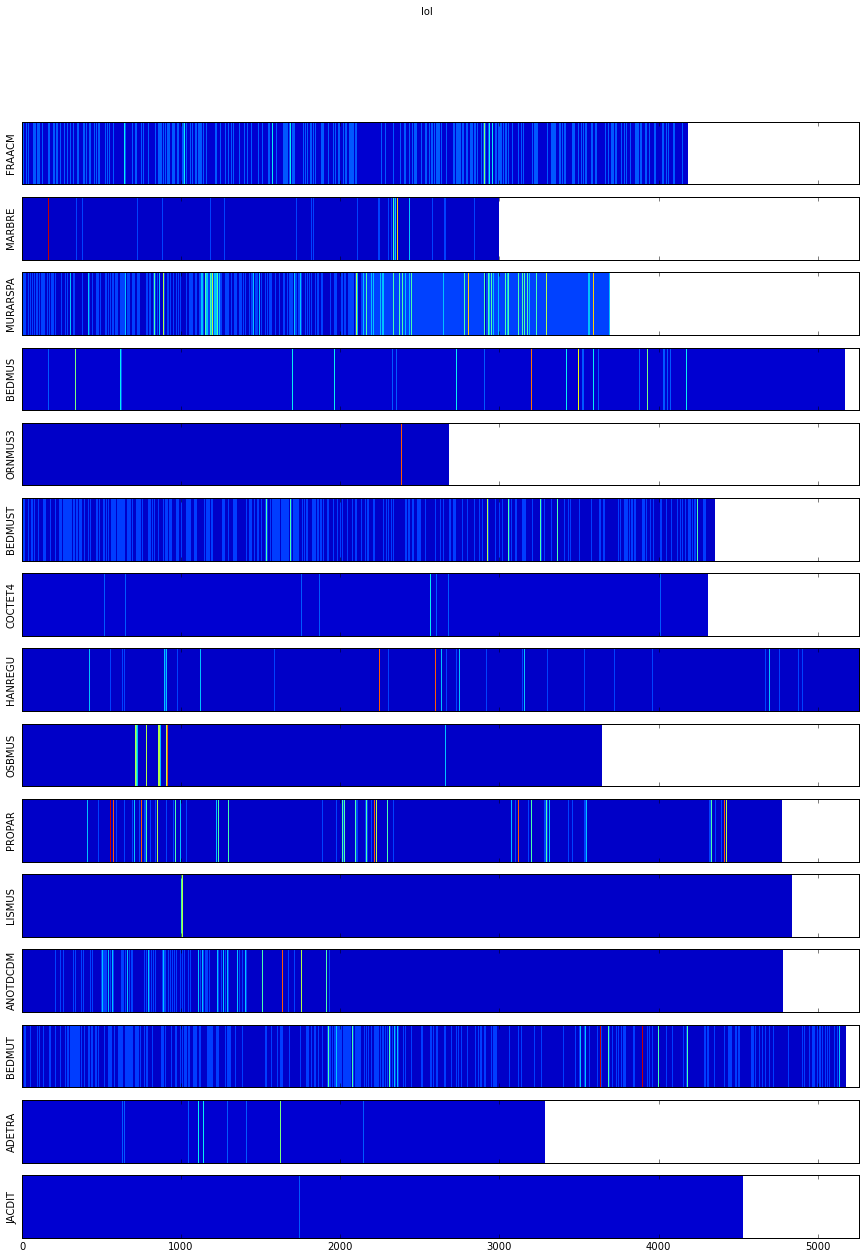

In [163]:
plot_heatmap()

----

## More stuff about the indexes compiled earlier 

Let's have a look inside this index, shall we?

In [135]:
def ngram_index_freq(index, blacklist=[]):
    freqs = Counter()
    for ngram, locations in index.items():
        if not bool(set(ngram) & set(blacklist)):
            freqs[ngram] += len(locations)
    return freqs

freq = ngram_index_freq(filtered_idx)
freq.most_common(20)

[(('c', 'd', 'e', 'f', 'g'), 609),
 (('a', 'b', 'c', 'd', 'e'), 394),
 (('b', 'c', 'd', 'e', 'f'), 386),
 (('ut', 're', 'mi', 'fa', 'sol'), 307),
 (('re', 'mi', 'fa', 'sol', 'la'), 286),
 (('d', 'e', 'f', 'g', 'a'), 233),
 (('in', 'g', 'sol', 're', 'ut'), 212),
 (('in', 'a', 'la', 'mi', 're'), 199),
 (('in', 'c', 'sol', 'fa', 'ut'), 165),
 (('a', 'c', 'd', 'e', 'f'), 124),
 (('e', 'f', 'g', 'a', 'b'), 116),
 (('g', 'a', 'b', 'c', 'd'), 114),
 (('f', 'g', 'a', 'b', 'c'), 110),
 (('re', 'mi', 'fa', 'sol', 'la.'), 106),
 (('aut', 'duos', 'tres', 'aut', 'quatuor'), 106),
 (('d', 'e', 'f', 'g', 'aa'), 104),
 (('in', 'd', 'la', 'sol', 're'), 102),
 (('gloria', 'patri', 'et', 'filio', 'et'), 98),
 (('patri', 'et', 'filio', 'et', 'spiritui'), 93),
 (('a', 'dia', 'quod', 'est', 'de'), 91)]

There's a lot of scale segments (a.k.a 'boilerplate')... We could do a couple of things about this, I suppose. Let's find out the most common tokens in the dataset and exclude any ngrams from this list which contain a token that appears close to the top of that list.

In [136]:
def count_all_tokens(id_tokenized_map):
    all_tokens = []
    for _id, tokens in id_tokenized_map.items():
        all_tokens.extend(tokens)
    return Counter(all_tokens)

token_counter = count_all_tokens(id_tokenized_map)

def top_n_tokens(id_tokenized_map, n):
    token_counter = count_all_tokens(id_tokenized_map)
    return [t[0] for t in token_counter.most_common(n)]

top_100_tokens = top_n_tokens(id_tokenized_map, 100)

freq = ngram_index_freq(filtered_idx, blacklist=top_100_tokens)
freq.most_common(20)

[(('c.', 'd.', 'e.', 'f.', 'g.'), 90),
 (('b.', 'c.', 'd.', 'e.', 'f.'), 65),
 (('a.', 'b.', 'c.', 'd.', 'e.'), 61),
 (('2', '3', '4', '5', '6'), 37),
 (('1', '2', '3', '4', '5'), 36),
 (('3', '4', '5', '6', '7'), 34),
 (('aa', 'bb', 'cc', 'dd', 'ee'), 32),
 (('d.', 'e.', 'f.', 'g.', 'a.'), 28),
 (('4', '5', '6', '7', '8'), 28),
 (('divisio', 'ii', 'authenticus', 'protus', 'antiphona'), 28),
 (('hypate', 'hypaton', 'parhypate', 'hypaton', 'lichanos'), 26),
 (('h', 'i', 'k', 'l', 'm'), 25),
 (('gravisque', 'mixtura', 'suaviter', 'uniformiterque', 'auribus'), 25),
 (('acuti', 'soni', 'gravisque', 'mixtura', 'suaviter'), 25),
 (('ante', 'longam', 'valet', 'tria', 'tempora'), 24),
 (('.a.', 'secundus', '.b.', 'tertius', '.c.'), 24),
 (('mediatis', 'manus', 'musicalis', 'partibus', 'existentium'), 24),
 (('secundus', '.b.', 'tertius', '.c.', 'quartus'), 23),
 (('hypaton', 'parhypate', 'hypaton', 'lichanos', 'hypaton'), 23),
 (('.b.', 'tertius', '.c.', 'quartus', '.d.'), 23)]

A bit better this time. Let's check out the provenance of the phrase:

> acuti soni gravisque mixtura suaviter

which appears 26 times in the corpus.

In [92]:
locations = filtered_idx[('acuti', 'soni', 'gravisque', 'mixtura', 'suaviter')]
for _id, position in locations:
    info = id_info_map[_id.split('_')[0]]
    print(" / ".join([_id, info['author'][:15], info['title'][:15], str(position), info['century']]))

ANO1DEM_157 / Anonymous I / De musica antiq / 24 / 14th
GAFEXT_255 / Gaffurio, Franc / Extractus parvu / 14 / 15th
JACCDM_7 / Jacobus Leodien / Compendium de m / 31 / 14th
JACSP4_501 / Jacobus Leodien / Speculum musica / 18 / 14th
MARLUC5_1 / Marchetus de Pa / Lucidarium, tra / 0 / 14th
MURMUSI_27 / Johannes de Mur / Musica speculat / 14 / 14th
MURMSPEW_19 / Johannes de Mur / Musica speculat / 24 / 14th
IERTDM1_289 / Ieronimus de Mo / Tractatus de mu / 25 / 13th
CICNM1_257 / Ciconia, Johann / Nova musica, li / 3 / 15th
REGDHI_55 / Regino Prumiens / De harmonica in / 33 / 9th-11th
MARLU5_0 / Marchetus de Pa / Lucidarium, tra / 45 / 14th
BOEMUS1_68 / Boethius, Anici / De institutione / 20 / 6th-8th
UGODEC1A_310 / Ugolino Urbevet / Declaratio musi / 4 / 15th
REGHAR_56 / Regino Prumiens / Epistola de har / 34 / 9th-11th
QUAPRIB4_195 / Anonymous / Quatuor Princip / 32 / 14th
UGODEC5_111 / Ugolino Urbevet / Declaratio musi / 30 / 15th
MURMSP_19 / Johannes de Mur / Musica speculat / 22 / 14th

In [95]:
locations = filtered_idx[('acuti', 'soni', 'gravisque', 'mixtura', 'suaviter')]

authors_involved = []

for _id, position in locations:
    info = id_info_map[_id.split('_')[0]]
    authors_involved.append(_id.split('_')[0])

In [108]:
def construct_regex():
    regex = []
    template = '(.*{}.*)'
    for a in list(set(authors_involved)):
        regex.append(template.format(a))
    out = '|'.join(regex)
    return out

In [109]:
construct_regex()

'(.*BOEMUS1.*)|(.*UGODEC5.*)|(.*ANO1DEM.*)|(.*MURMUSI.*)|(.*MURMSPEW.*)|(.*QUAPRIB4.*)|(.*JACSP4.*)|(.*CICNM1.*)|(.*IERTRA1.*)|(.*REGHAR.*)|(.*MURMSPE.*)|(.*IERTDM1.*)|(.*GUIENC.*)|(.*GAFEXT.*)|(.*MARLU5.*)|(.*MARLUC5.*)|(.*MURMSP.*)|(.*JACSP2A.*)|(.*REGDHI.*)|(.*UGODEC1A.*)|(.*MURMUS.*)|(.*BOEDIM1.*)|(.*JACCDM.*)'

## Worked example 1

How about this for a research question?

> What treatises does Descartes allude to/paraphrase in his *Compendium*?

1. Use id_shingled_map to get the shingled version of Descartes' text, 'DESCOM'
2. Look up each n-gram in the filtered_idx for concordances
3. Filter out disinteresting ones
4. Print out the output

In [ ]:
query_id = 'DESCOM'
query_shingled = [ngram for ngram in id_shingled_map[query_id]]

len(query_shingled)

In [ ]:
response = []

for query_ngram in query_shingled:
    locations = filtered_idx.get(query_ngram, None)
    if locations is not None:
        response.append((query_ngram, locations))